# Amplitude noise simulations

## Import zone

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as ct
import imageio.v2 as imageio
import os

from matplotlib.colors import LogNorm
from electrode import polygons, System, shaped

from src.systems.linear_traps import ThreeRFTrap
from src.io.loading import load_threeRF_geometry
from src.geometry.geometry_utils import check_all_ccw
from src.io.saving import convert_gdsii_to_gdspy


from matplotlib import rcParams

# --- Style settings (as before) ---
rcParams['font.family'] = 'STIXGeneral'
rcParams['mathtext.fontset'] = 'stix'
rcParams['axes.unicode_minus'] = False
rcParams.update({
    "font.size": 14,
    "axes.labelsize": 15,
    "axes.titlesize": 15,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1.2,
    "lines.linewidth": 1.5,
    "grid.alpha": 0.6,
    "grid.linestyle": "--",
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})

## Load trap geometry

In [2]:
geometry = load_threeRF_geometry("/home/kallo27/thesis/src/resources/ThreeRF_params.json")

# Trench width
trench_width = 5

# Set segmentation flags
flags = {
    "build_outer_RF": True,
    "build_central_RF": True,
}

# Build trap
trap = ThreeRFTrap(geometry, trench_width, flags)
system = trap.build()

check_all_ccw(system)

# Save trap to a gds file
trap_polygons = polygons.Polygons.from_system(system)

trap_polygons_gds = trap_polygons.to_gds(
    scale=1.,
    poly_layer=(0, 0),
    gap_layer=(1, 0),
    text_layer=(2, 0),
    via_layer=(10, 0),
    phys_unit=1.,
    name="trap_polygons",
    edge=13000,
    gap_width=5
)

gdspy_library = convert_gdsii_to_gdspy(trap_polygons_gds)
gdspy_library.write_gds('RF_heating.gds')

# Define subsystems sorted into RF and DC electrodes
s_RF = System([entry for entry in system if not entry.dc])
s_DC = System([entry for entry in system if not entry.rf])

# Check which electrode is in which subsystem
print("RF-electrodes: {}".format(s_RF.names))
print("DC-electrodes: {}".format(s_DC.names))

All electrodes are CCW.
RF-electrodes: ['RF_1', 'RF_2a', 'RF_2b']
DC-electrodes: []


## Build system and compute pseudopotential

In [3]:
csi_values = np.linspace(-1., 1.5, 1001)
csi_values[csi_values == 0] = 1e-12
x0 = (0., 0., 350.)
x1 = (0., 0., 10.)
minimum_positions_0 = []
minimum_positions_1 = []
pot_values_0 = []
pot_values_1 = []
secular_frequencies_0 = []
secular_frequencies_1 = []

L = 1e-6 # um length scale
M = 40 * ct.atomic_mass # ion mass (calcium)
Q = 1 * ct.elementary_charge # ion charge (single-ion)
Omega = 2 * np.pi * 19e6
V0 = 100

scale = Q / (2 * Omega * np.sqrt(M))

for csi in csi_values:
    voltages = {
        "central_RF": {"attr": "rf", "value": csi},
        "outer_RF": {"attr": "rf", "value": 1},
    }

    system = trap.build(voltages)

    try:
        if csi > 0.75:
            x0[0] += 1
            x1[0] -= 1
        x0 = system.minimum(x0=(x0[0], x0[1], x0[2]), axis=(0,2), coord=np.identity(3), method="Powell")
        minimum_positions_0.append(x0)
        pot_values_0.append(scale**2 * system.potential(x=x0, derivative=0)[0] * (V0/L)**2)

        if csi > 0.16:
            x1 = system.minimum(x0=(x1[0], x1[1], x1[2]), axis=(0,2), coord=np.identity(3), method="Powell")
            pot_values_1.append(scale**2 * system.potential(x=x1, derivative=0)[0] * (V0/L)**2)
            minimum_positions_1.append(x1)
            
        # Compute secular frequencies
        curve_z_0 = system.modes(x0)
        omega_sec_0 = np.sqrt(abs(curve_z_0[0]) / M * (scale * V0 / L**2)**2)
        secular_frequencies_0.append(omega_sec_0)
        
        if csi > 0.16:
            curve_z_1 = system.modes(x1)
            omega_sec_1 = np.sqrt(abs(curve_z_1[0]) / M * (scale * V0 / L**2)**2)
            secular_frequencies_1.append(omega_sec_1)
    except:
        print(csi, "minimum not found")

/home/kallo27/anaconda3/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-linux-x86_64.egg/electrode/system.py:439: RuntimeWarning: Method Powell does not use gradient information (jac).
  res = optimize.minimize(fun=f, x0=x0, jac=g, hess=h,
/home/kallo27/anaconda3/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-linux-x86_64.egg/electrode/system.py:439: RuntimeWarning: Method Powell does not use Hessian information (hess).
  res = optimize.minimize(fun=f, x0=x0, jac=g, hess=h,


In [4]:
# Convert to arrays for slicing
min_pos_0 = np.array(minimum_positions_0)
min_pos_1 = np.array(minimum_positions_1)

In [5]:
def plot_minima_and_frequencies(csi_values, min_pos_0, min_pos_1, sec_freq_0, sec_freq_1):
    fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
    colors = {"minimum_1": "#003366", "minimum_2": "#8B0000"}

    # === 1. X-coordinates of minima ===
    axs[0].plot(csi_values[csi_values > 0.16], min_pos_1[:, 0], label="Minimum 2", color=colors["minimum_2"])
    axs[0].plot(csi_values, min_pos_0[:, 0], label="Minimum 1", color=colors["minimum_1"])
    axs[0].set_ylabel(r'$x \ \mathrm{(\mu m)}$')
    axs[0].grid(True)
    handles, labels = axs[0].get_legend_handles_labels()
    axs[0].legend(handles[::-1], labels[::-1], loc='upper left')

    # === 2. Y-coordinates of minima ===
    axs[1].plot(csi_values[csi_values > 0.16], min_pos_1[:, 2], label="Minimum 2", color=colors["minimum_2"])
    axs[1].plot(csi_values, min_pos_0[:, 2], label="Minimum 1", color=colors["minimum_1"])
    axs[1].set_ylabel(r'$y \ \mathrm{(\mu m)}$')
    axs[1].grid(True)
    handles, labels = axs[1].get_legend_handles_labels()
    axs[1].legend(handles[::-1], labels[::-1], loc='lower left')

    # === 3. Secular frequencies ===
    secular_frequencies_0 = np.array(sec_freq_0)
    secular_frequencies_1 = np.array(sec_freq_1)
    sec_01 = secular_frequencies_0[:, 1] / (2 * np.pi * 1e6)
    sec_02 = secular_frequencies_0[:, 2] / (2 * np.pi * 1e6)
    sec_11 = secular_frequencies_1[:, 1] / (2 * np.pi * 1e6)
    sec_12 = secular_frequencies_1[:, 2] / (2 * np.pi * 1e6)

    axs[2].plot(csi_values[csi_values > 0.16], sec_11, label='Minimum 2', color=colors["minimum_2"], linestyle='-')
    axs[2].plot(csi_values, sec_01, label='Minimum 1', color=colors["minimum_1"], linestyle='-')
    axs[2].set_xlabel(r"RF amplitude ratio $(\xi_{\mathrm{RF}})$")
    axs[2].set_ylabel("Radials (MHz)")
    axs[2].grid(True)
    handles, labels = axs[2].get_legend_handles_labels()
    axs[2].legend(handles[::-1], labels[::-1], loc='upper left')
     
    # Shaded regions
    for ax in axs:
        # Highlight regions
        ax.axvspan(-1, 0.76, color="#EEE8AC", alpha=0.5)   # light yellow
        ax.axvspan(0.76, 1.3, color="#FBC901", alpha=0.5)  # bright yellow
        ax.axvspan(1.3, 1.5, color="#D89B00", alpha=0.5)   # darker, richer yellow-orange

        # Add dashed vertical line at 0.16
        ax.axvline(0.16, color='grey', linestyle='--', linewidth=1.3)

    fig.align_ylabels([axs[0], axs[1], axs[2]])
    plt.tight_layout()
    return fig

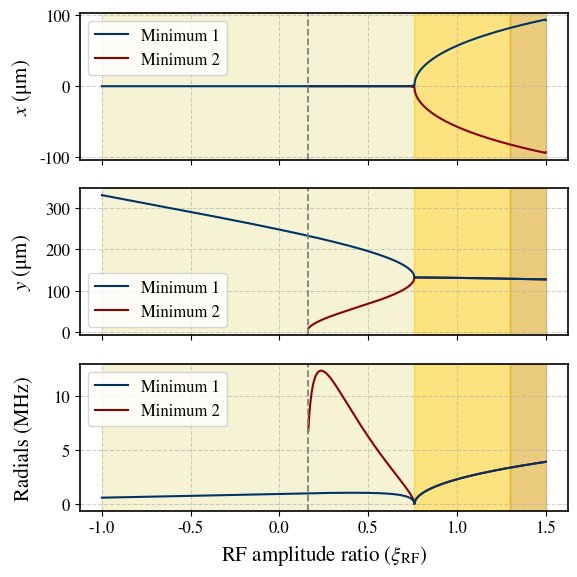

In [6]:
fig = plot_minima_and_frequencies(csi_values, min_pos_0, min_pos_1, secular_frequencies_0, secular_frequencies_1)
fig.savefig("/home/kallo27/thesis/thesis_images/minima_RF_ratio.pdf", bbox_inches="tight")

## Plot nice for thesis 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_selected_frames(trap, scale, V0, L, Q, indices, 
                         csi_values=None, x0_init=(0., 0., 350.), x1_init=(0., 0., 10.),
                         n=100, xmin=-400., xmax=400., zmin=10., zmax=500.):

    if csi_values is None:
        csi_values = np.linspace(-1., 1.5, 1001)

    frames_data = {}
    x0, x1 = list(x0_init), list(x1_init)

    for i, csi in enumerate(csi_values):
        voltages = {
            "central_RF": {"attr": "rf", "value": scale * V0 * csi},
            "outer_RF": {"attr": "rf", "value": scale * V0},
        }

        try:
            system = trap.build(voltages)

            if csi > 0.6:
                x0[0] += 1
                x1[0] -= 1

            x0 = list(system.minimum(x0=tuple(x0), axis=(0,1,2), coord=np.identity(3), method="Powell"))
            if csi < 1.2:
                s0 = list(system.saddle([0, x0[1], x0[2] + 150]))
            else:
                s0 = list(system.saddle([x0[0]-10, x0[1], x0[2] + 50]))
                
            if csi > 0.2:
                x1 = list(system.minimum(x0=tuple(x1), axis=(0,1,2), coord=np.identity(3), method="Powell"))

            if csi < 0.7:
                s1 = list(system.saddle([0, x0[1], x0[2] - 75]))
            elif 0.7 < csi < 1.2:
                s1 = list(system.saddle([0, x0[1], x0[2]]))
            else:
                s1 = list(system.saddle([x1[0]+10, x1[1], x1[2] + 50]))
                
            if i in indices:
                y_cut = x0[1]
                xyz = np.mgrid[xmin:xmax:1j*n, y_cut:y_cut+0.1, zmin:zmax:1j*n]
                pot = shaped(system.potential)(xyz) / L**2
                x, z, p = (_.reshape(n, n) for _ in (xyz[0], xyz[2], pot))

                delta_p = (p - np.min(p))/Q
                delta_p[delta_p <= 0] = 1e-20

                frames_data[i] = (csi, x, z, delta_p, tuple(x0), tuple(x1), tuple(s0), tuple(s1))

        except Exception as e:
            print(f"ξ = {csi:.3f}: skipped ({e})")

    # smaller figure
    fig, axes = plt.subplots(1, len(indices), figsize=(4*len(indices), 4), sharey=True)
    if len(indices) == 1:
        axes = [axes]

    ims = []

    for ax, idx in zip(axes, indices):
        if idx not in frames_data:
            ax.text(0.5, 0.5, f"Frame {idx} missing", ha='center', va='center')
            ax.axis('off')
            continue

        csi, x, z, delta_p, x0, x1, s0, s1 = frames_data[idx]
        im = ax.imshow(delta_p.T, origin='lower', extent=(xmin, xmax, zmin, zmax),
                       norm=LogNorm(vmin=1e-2, vmax=1), cmap='viridis', aspect='auto')
        im.set_interpolation('bilinear')
        ims.append(im)

        ax.scatter(x0[0], x0[2], color='cyan', marker='o', s=10)
        ax.scatter(s0[0][0], s0[0][2], color='white', marker='x', s=20)
        ax.scatter(s1[0][0], s1[0][2], color='white', marker='x', s=20)
        if csi > 0.16:
            ax.scatter(x1[0], x1[2], color='cyan', marker='o', s=10)

        # ax.set_title(rf"$\xi_{{\mathrm{{RF}}}} = {csi:.3f}$", fontsize=14)
        ax.set_xlabel(r'$x \ \mathrm{(\mu m)}$', fontsize=15)
        ax.tick_params(axis='both', labelsize=12)
        ax.set_xticklabels([]) 

    axes[0].set_ylabel(r'$y \ \mathrm{(\mu m)}$', fontsize=15)

    # single colorbar on the right
    cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77])  # [left, bottom, width, height]
    cbar = fig.colorbar(ims[0], cax=cbar_ax, label=r"$\mathrm{log}(\Phi_\mathrm{RF}) \ (\mathrm{a.u.})$")
    cbar.ax.yaxis.label.set_size(15)       # set label font size
    cbar.set_ticks([])
    
    fig.subplots_adjust(wspace=0.05)  # reduce horizontal spacing

    return fig


/home/kallo27/anaconda3/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-linux-x86_64.egg/electrode/system.py:439: RuntimeWarning: Method Powell does not use gradient information (jac).
  res = optimize.minimize(fun=f, x0=x0, jac=g, hess=h,
/home/kallo27/anaconda3/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-linux-x86_64.egg/electrode/system.py:439: RuntimeWarning: Method Powell does not use Hessian information (hess).
  res = optimize.minimize(fun=f, x0=x0, jac=g, hess=h,


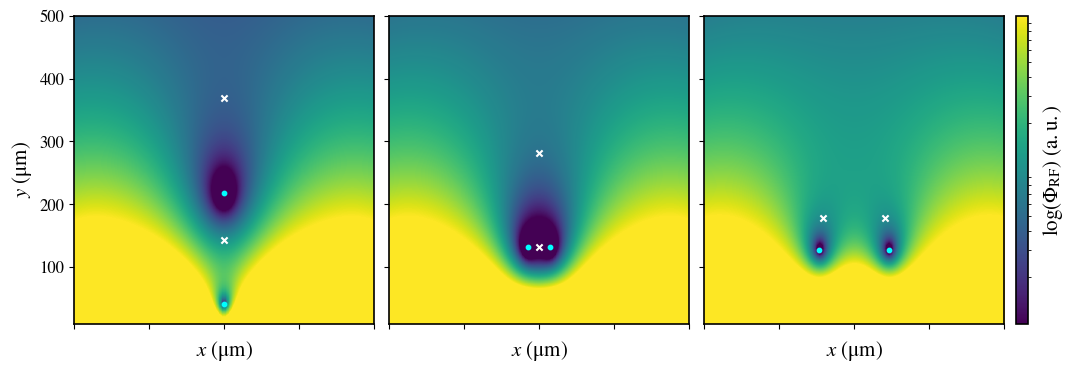

In [8]:
# Example: visualize three specific frames
fig = plot_selected_frames(trap, scale, V0, L, Q, indices=[520, 730, 1000])
fig.savefig("/home/kallo27/thesis/thesis_images/ps_RF_ratio.pdf", bbox_inches="tight")

## MC simulations

In [ ]:
def MC_noisy_potential(csi_val, x0, trap, mean_csi, sigma_csi, num_samples, mode="mixed"):
    pot_mc = []
    for _ in range(num_samples):
        if mode == "mixed":
            voltages_mc = {
                "central_RF": {"attr": "rf", "value": csi_val + np.random.normal(mean_csi, sigma_csi)},
                "outer_RF": {"attr": "rf", "value": 1 + np.random.normal(mean_csi, sigma_csi)},
            }
        elif mode == "outer":
            voltages_mc = {
                "central_RF": {"attr": "rf", "value": csi_val},
                "outer_RF": {"attr": "rf", "value": 1 + np.random.normal(mean_csi, sigma_csi)},
            }
        elif mode == "inner":
            voltages_mc = {
                "central_RF": {"attr": "rf", "value": csi_val + np.random.normal(mean_csi, sigma_csi)},
                "outer_RF": {"attr": "rf", "value": 1},
            }
        else:
            raise ValueError(f"Unknown mode: {mode}")

        system_mc = trap.build(voltages_mc)
        pot_mc.append(scale**2 * system_mc.potential(x=x0, derivative=0)[0] * (V0/L)**2)

    return np.mean(pot_mc)


In [18]:
csi_values = np.linspace(-1., 1.5, 1001)
csi_values[csi_values == 0] = 1e-12
x0 = (0., 0., 350.)
pot_values_0 = []
pot_values_outer = []
pot_values_inner = []
pot_values_mixed = []

sigma_csi = 1e-4
mean_csi = 0
num_samples = 1000

for i in range(len(csi_values)):
    voltages = {
        "central_RF": {"attr": "rf", "value": csi_values[i]},
        "outer_RF": {"attr": "rf", "value": 1},
    }
    
    system = trap.build(voltages)

    try:
        if csi_values[i] > 0.75:
            x0[0] += 1
        x0 = system.minimum(x0=(x0[0], x0[1], x0[2]), axis=(0,2), coord=np.identity(3), method="Powell")
        pot_values_0.append(scale**2 * system.potential(x=x0, derivative=0)[0] * (V0/L)**2)

    except:
        print(csi_values[i], "minimum not found")

    mean_pot_outer = MC_noisy_potential(csi_values[i], x0, trap, scale, mean_csi, sigma_csi, num_samples, mode="outer")
    mean_pot_inner = MC_noisy_potential(csi_values[i], x0, trap, scale, mean_csi, sigma_csi, num_samples, mode="inner")
    mean_pot_mixed = MC_noisy_potential(csi_values[i], x0, trap, scale, mean_csi, sigma_csi, num_samples, mode="mixed")
    
    pot_values_outer.append(mean_pot_outer)
    pot_values_inner.append(mean_pot_inner)
    pot_values_mixed.append(mean_pot_mixed)

/home/kallo27/anaconda3/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-linux-x86_64.egg/electrode/system.py:439: RuntimeWarning: Method Powell does not use gradient information (jac).
  res = optimize.minimize(fun=f, x0=x0, jac=g, hess=h,
/home/kallo27/anaconda3/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-linux-x86_64.egg/electrode/system.py:439: RuntimeWarning: Method Powell does not use Hessian information (hess).
  res = optimize.minimize(fun=f, x0=x0, jac=g, hess=h,


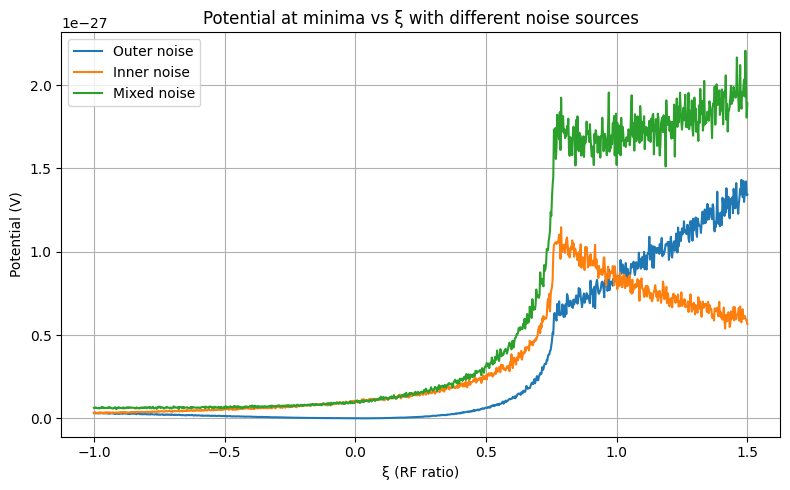

In [19]:
plt.figure(figsize=(8, 5))

# Plot all potentials
plt.plot(csi_values, pot_values_outer, label='Outer noise', color='tab:blue')
plt.plot(csi_values, pot_values_inner, label='Inner noise', color='tab:orange')
plt.plot(csi_values, pot_values_mixed, label='Mixed noise', color='tab:green')

# Axis labels and title
plt.xlabel('ξ (RF ratio)')
plt.ylabel('Potential (V)')
plt.title('Potential at minima vs ξ with different noise sources')

# Grid and legend
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()